# Проект по анализу оттока и кластеризации пользователей для фитнес-клуба

## Небоходимо спрогнозировать вероятность оттока позователей на основе исторических данных - анкет клиентов, а также провести кластеризацию клиентов на группы.  


[1. Загрузка необходимых библиотек ](#dependancy_download)  
[2. Загрузка и знакомство с данными](#data_download)  
[3. Предобработка данных](#data_preprocessing)  
[4. Моделирование оттока клиентов](#modeling)  
[5. Кластеризация клиентов](#clustering)  
[6. Выводы и рекоммендации](#conclusions)  

<a id='dependancy_download'></a>
### 1. Загрузка необходимых библиотек 

In [201]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage

import itertools
from itertools import combinations


<a id='data_download'></a>
### 2. Загрузка и знакомство с данными

In [4]:
path_local = '/Users/juliagrobman/Downloads/gym_churn.csv'
path_global = '/datasets/gym_churn.csv'

if os.path.exists(path_local):
    data = pd.read_csv(path_local)
elif os.path.exists(path_global):
    data = pd.read_csv(path_global)
else:
    print('ERROR WITH DATA PATH')


In [5]:
data.head()

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

#### Датасет содержит 4000 строк, столбец 'Churn' содержит целевой признак  
#### Пропусков нет, тип данных соотвествует содержанию

In [7]:
# Приведем столбцы к нижнему регистру
data.columns = data.columns.str.lower()

In [8]:
data.head()

gender  near_location  partner  promo_friends  phone  contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   group_visits  age  avg_additional_charges_total  month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   lifetime  avg_class_frequency_total  avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   churn  
0      0  
1      0  
2      0  
3      0  
4      0

In [9]:
data.describe()

gender  near_location      partner  promo_friends        phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       avg_additional_charges_total  month_to_end_contract     lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       avg_class_frequency_total  avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [11]:
stayed = data.query('churn==0')
quit = data.query('churn==1')

In [12]:
data.groupby('churn', as_index=False).mean()

churn    gender  near_location   partner  promo_friends     phone  \
0      0  0.510037       0.873086  0.534195       0.353522  0.903709   
1      1  0.510839       0.768143  0.355325       0.183789  0.902922   

   contract_period  group_visits        age  avg_additional_charges_total  \
0         5.747193      0.464103  29.976523                    158.445715   
1         1.728558      0.268615  26.989632                    115.082899   

   month_to_end_contract  lifetime  avg_class_frequency_total  \
0               5.283089  4.711807                   2.024876   
1               1.662582  0.990575                   1.474995   

   avg_class_frequency_current_month  
0                           2.027882  
1                           1.044546

Видим, что некоторые средние значения признаков в обеих группах не отличаются или отличаются несильно: пол, наличие контактного телефона, проживание или работа в районе, где находится финтес-центр, другие же отличаются очень заметно: длительность действующего абонемента, факт посещения групповых занятий и тп

In [220]:
# Построим распределения признаков для тех, кто ушел, и тех, кто остался
for col in data.drop(['churn','gender','phone'], axis=1).columns:
    fig = px.histogram(data, x = col, color='churn',\
        title = 'Histogram of {}'.format(col))
    

    fig.show()

Распределение признаков похоже для уходящих и остающихся клиентов, обращают на себя внимание выбросы в признаках "avg_class_frequency_current_month", "lifetime","avg_class_frequency_current_month".  
  
Посмотрим подробнее в разделе про педобработку данных.

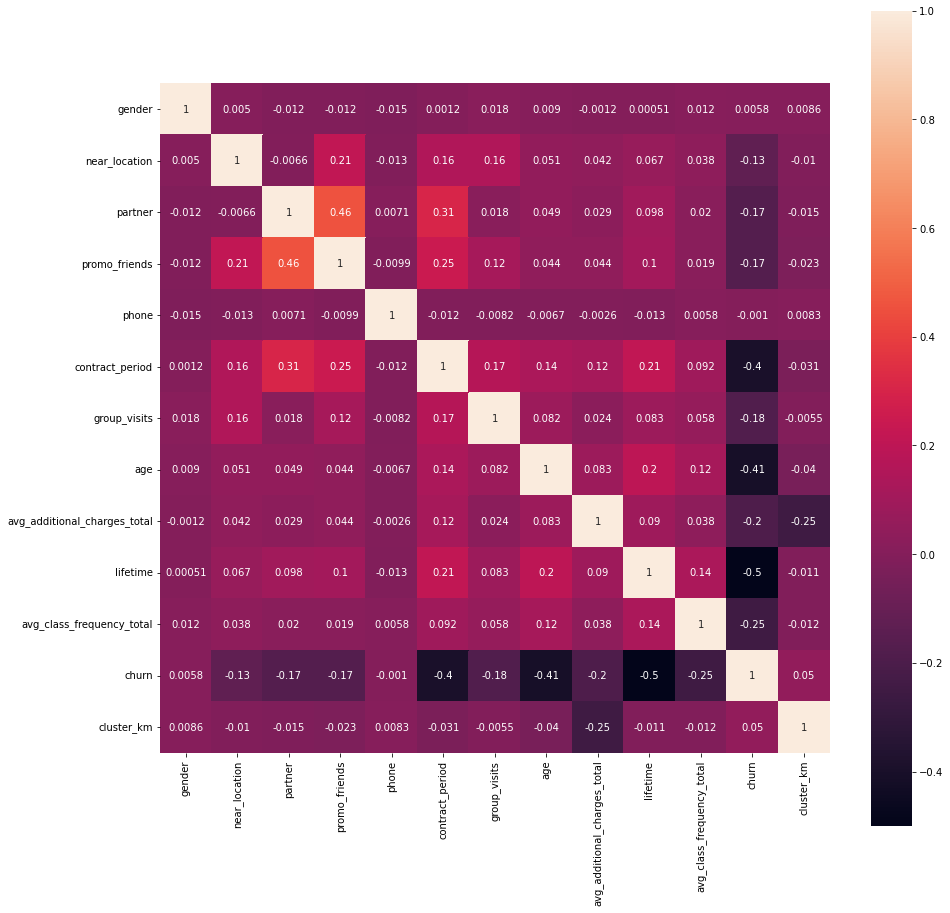

In [221]:
# Построим матрицу корреляций
cm = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cm, square=True, annot=True)
plt.title = 'Матрица корреляции'
plt.show()

По хитмапу видим, что есть сильно скоррелированные признаки:   
* 'avg_class_frequency_current_month', 'avg_class_fequency_total'  
* 'contract_period' , 'month_to_end_contract'  

удалим один из признаков в каждой паре

In [38]:
data = data.drop(['avg_class_frequency_current_month','month_to_end_contract'], axis=1)

<a id='data_preprocessing'></a>
### 3. Предобработка данных

In [48]:
#Проверим данные на выбросы:
# создадим список цисленных столбцов
numerical = ['age','avg_additional_charges_total','lifetime','avg_class_frequency_total']

In [50]:
# построим boxplot
for col in numerical:
    fig = px.box(data, y=col, title='Распределение {}'.format(col))
    fig.show()

In [55]:
# Видим, что в данных присутствут выбросы, удалим их:
data = data.query('(\
    age <= 37 ) \
    and (age >=21) \
    and (avg_additional_charges_total <=416) \
    and (lifetime <=11)\
    and (avg_class_frequency_total <=4.565)')

In [57]:
data.lifetime.max(), data.age.max()

(11, 37)

Произвели исследование и предобработку данных, удалили выбросы высококоррелированные столбцы, данные готовы для моделирования

<a id='modeling'></a>
### 4. Моделирование оттока клиентов

In [145]:
# обработаем данные
num_transformer = Pipeline([('scaler',StandardScaler())
])
cat_transormer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [146]:
num_features = numerical
cat_features = ['gender','near_location','partner','promo_friends','phone', 'contract_period','group_visits']

In [147]:
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transormer, cat_features)
])

In [148]:
# создадим pipeline логистической регрессии
pipe_lr = Pipeline([('preprocess',preprocessor),
('clf', LogisticRegression(random_state=123)) ])

# создадим pipeline случайного леса
pipe_rf = Pipeline([('preprocess',preprocessor),
('clf', RandomForestClassifier(random_state=123))])

In [149]:
#добвим параметры для моделей

grid_params_lr = [{
    'clf__penalty' : ['l1','l2'],
    'clf__C' :  [1.0,0.5],
    'clf__solver' : ['liblinear']

}]

grid_params_rf = [{
    'clf__criterion' : ['gini','entropy'],
    'clf__max_depth' : np.arange(10,50,5),
    'clf__n_estimators': np.arange(20,200,10)
}]


In [150]:
# Создадим GridSearch
LR = GridSearchCV(estimator=pipe_lr,
param_grid=grid_params_lr,
scoring = 'f1', cv=5)

RF = GridSearchCV(estimator = pipe_rf, 
param_grid = grid_params_rf,
scoring='f1', cv=5)

In [151]:
grids = [LR, RF]
grid_dict = {0: 'LogisticRegression', 1:'Random Forest'}

In [152]:
#разделим выборки
features = data.drop('churn', axis=1)
target = data['churn']
features_train, features_test, target_train, target_test = train_test_split \
    (features, target, test_size=0.2, random_state=123)


In [186]:

print('Performing model optimizations...')
best_f1 = 0
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(features_train, target_train)
    print('Best params are : %s' % gs.best_params_)
# Best training data accuracy
    print('Best f1_score: %.3f' % gs.best_score_)
# Predict on test data with best params
    y_pred = gs.predict(features_test)
# Test data accuracy of model with best params
    f1 = metrics.f1_score(target_test, y_pred)
    print('Test set f1 score for best params: {:.2f}'.format(f1))
# Track best (highest test accuracy) model
    if f1 > best_f1:
        best_f1 = f1
        best_gs = gs
        best_clf = idx

print('\nClassifier with best test set f1: %s' % grid_dict[best_clf])
        


Performing model optimizations...

Estimator: LogisticRegression
Best params are : {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best f1_score: 0.810
Test set f1 score for best params: 0.82

Estimator: Random Forest
Best params are : {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 90}
Best f1_score: 0.794
Test set f1 score for best params: 0.83

Classifier with best test set f1: Random Forest


In [187]:
reg = LogisticRegression()
reg.fit(features_train, target_train)
reg_pred = reg.predict(features_test)
reg_f1 = metrics.f1_score(target_test, reg_pred)
reg_pres = metrics.precision_score(target_test, reg_pred)
reg_recall = metrics.recall_score(target_test,reg_pred)
reg_acc = metrics.accuracy_score(target_test, reg_pred)



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [188]:
forest = RandomForestClassifier()
forest.fit(features_train, target_train)
forest_pred = forest.predict(features_test)
forest_f1 = metrics.f1_score(target_test, forest_pred)
forest_pres = metrics.precision_score(target_test, forest_pred)
forest_recall = metrics.recall_score(target_test,forest_pred)
forest_acc = metrics.accuracy_score(target_test, forest_pred)

In [196]:
metrics = ['f1', 'percision','recall', 'accuracy']
LR_metrics = [reg_f1, reg_pres, reg_recall,reg_acc]
FOR_metrics = [forest_f1, forest_pres, forest_recall, forest_acc]

In [197]:
data_cumm = pd.DataFrame({'metircs':metrics, 'LR':LR_metrics, 'Forest':FOR_metrics})

In [198]:
data_cumm.sort_values

<bound method DataFrame.sort_values of      metircs   LR  Forest
0         f1 0.81    0.82
1  percision 0.81    0.85
2     recall 0.81    0.80
3   accuracy 0.90    0.91>

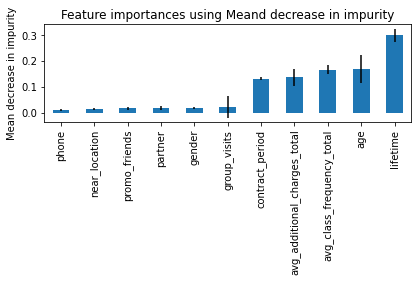

In [215]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=features.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Meand decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Самыми важными метриками являбются lifetime, age, avg_class_frequency_total

### Видим,  что модель Random forest лучше показала себя, демонстрируюя очень высокие метрики качества

<a id='clustering'></a>
### 5. Кластеризация клиентов

In [204]:
# проведем стандартизацию данных
sc = StandardScaler()
features_sc = sc.fit_transform(features)
linked = linkage(features_sc, method = 'ward')

# построим дендрограмму
fig = ff.create_dendrogram(linked)
fig.update_layout(width=800, height=500)
fig.show()

In [205]:
# проведем кластеризацию алгоритмом KMeans
km = KMeans(n_clusters=5, random_state=123)
labels = km.fit_predict(features)

data['cluster_km'] = labels

data.groupby('cluster_km').mean()

gender  near_location  partner  promo_friends  phone  \
cluster_km                                                         
0             0.50           0.84     0.49           0.31   0.89   
1             0.52           0.88     0.50           0.34   0.91   
2             0.49           0.82     0.48           0.30   0.91   
3             0.50           0.84     0.53           0.34   0.92   
4             0.52           0.84     0.47           0.29   0.90   

            contract_period  group_visits   age  avg_additional_charges_total  \
cluster_km                                                                      
0                      4.62          0.41 29.38                        164.89   
1                      5.37          0.44 29.32                        236.92   
2                      4.08          0.38 28.85                         33.17   
3                      5.65          0.41 29.76                        331.29   
4                      4.32          0.41 28.96                         99.36   

            lifetime  avg_class_frequency_total  churn  
cluster_km                                              
0               3.16                       1.87   0.26  
1               3.31                       1.88   0.20  
2               2.88                       1.82   0.38  
3               3.85                       1.96   0.08  
4               3.02                       1.83   0.33

Видим, что многие метрики не отличаются в разбиении по кластрам, осбенно различаются данные по avg_additional_charges_total

In [ ]:
plt.figure(figsize=(5, 5))
    sns.scatterplot(
        data['age'], data['phone'], hue=data['cluster_km'], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



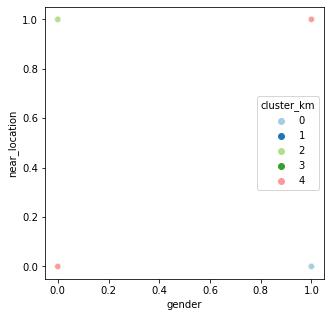

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



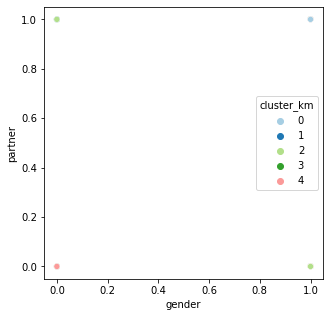

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



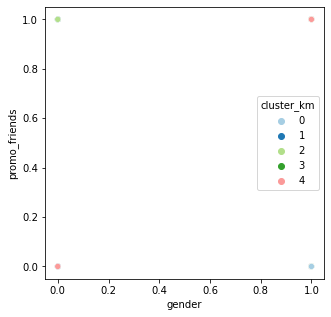

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



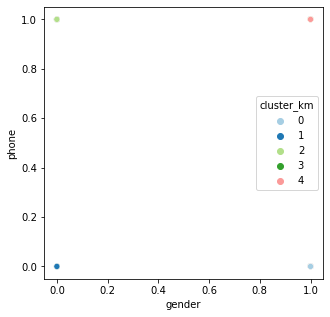

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



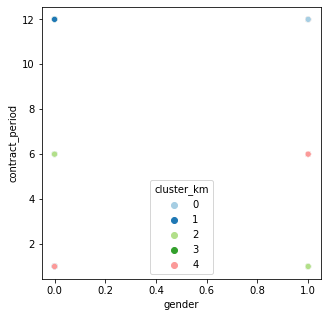

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



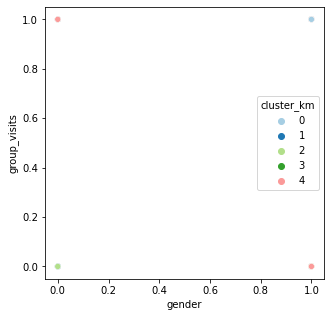

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



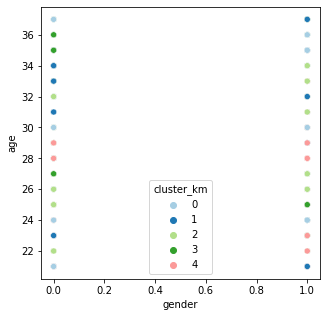

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



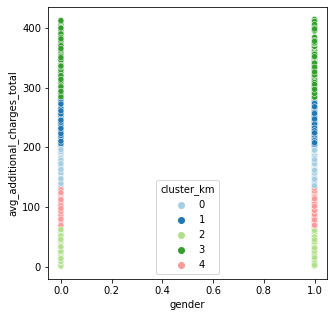

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



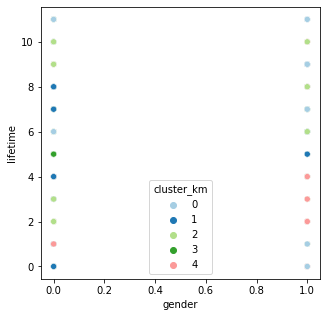

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



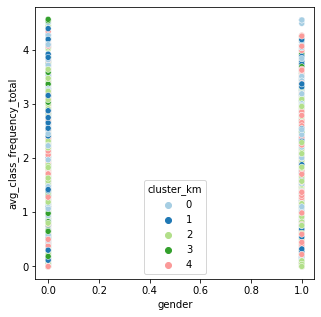

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



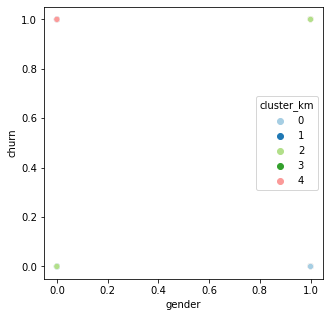

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



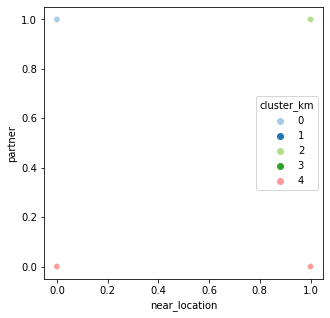

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



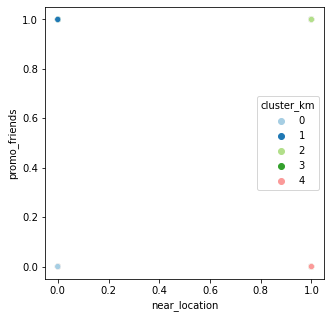

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



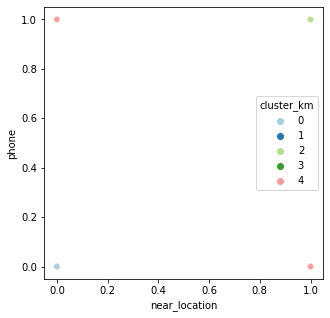

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



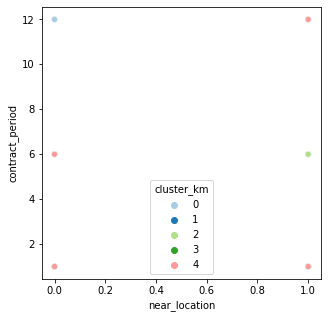

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



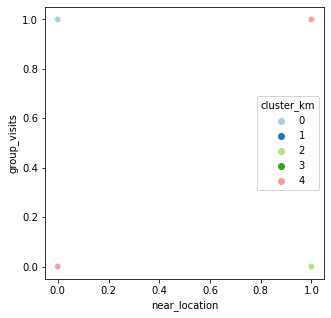

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



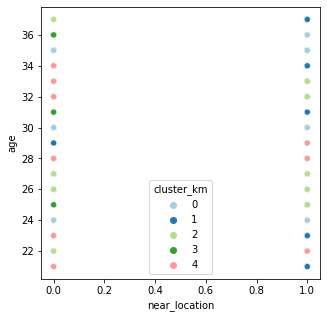

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



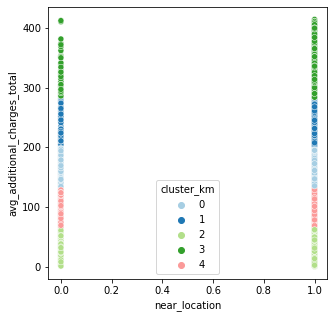

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



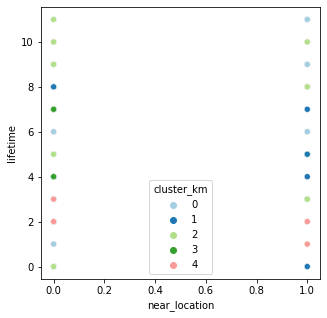

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



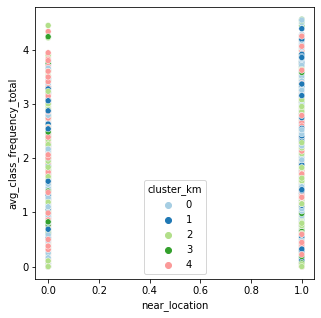

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



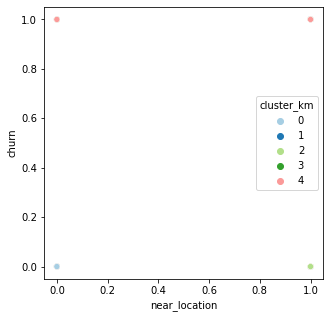

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



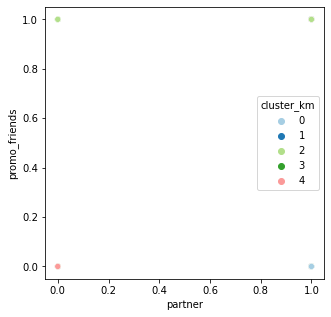

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



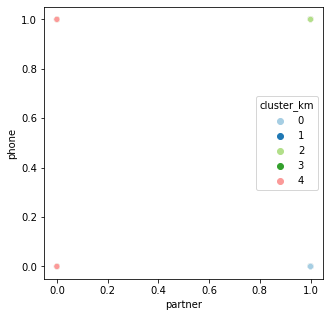

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



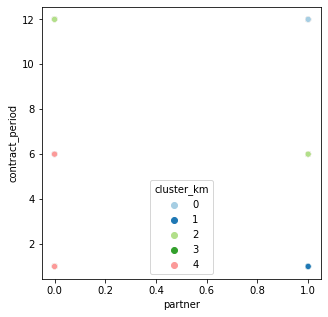

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



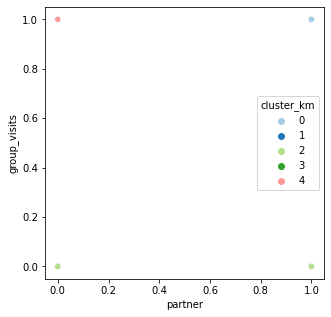

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



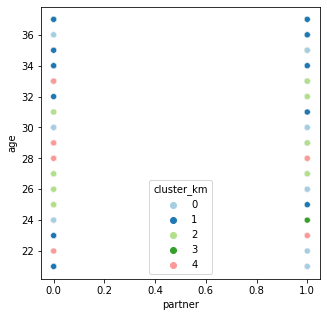

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



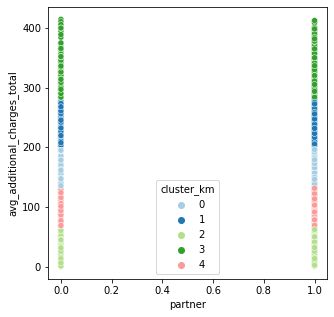

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



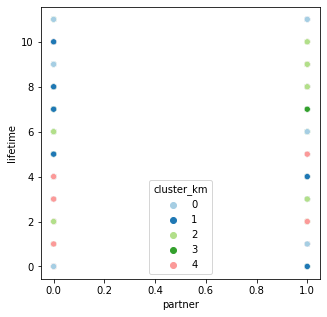

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



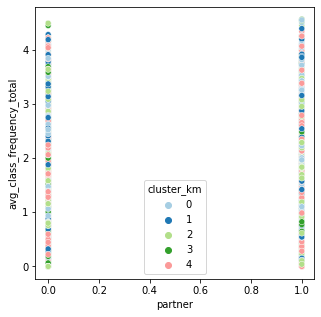

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



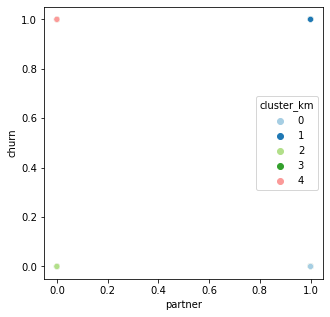

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



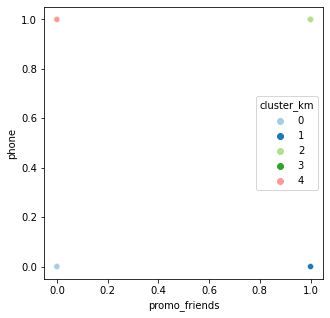

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



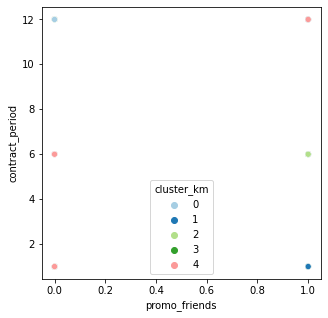

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



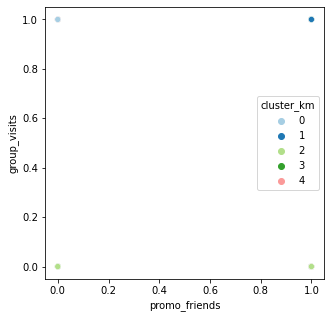

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



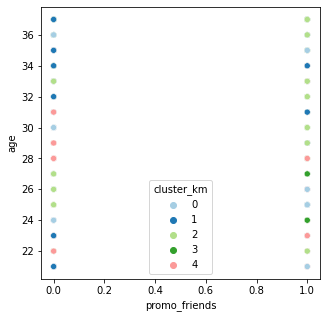

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



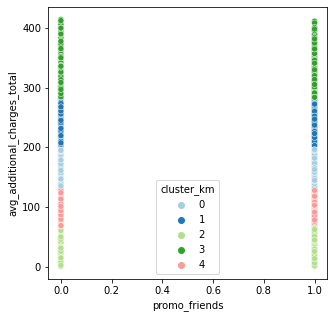

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



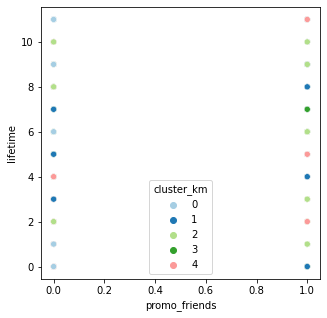

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



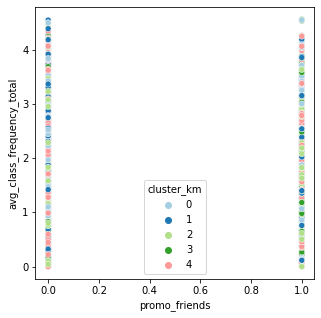

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



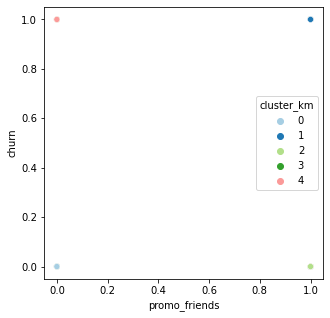

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



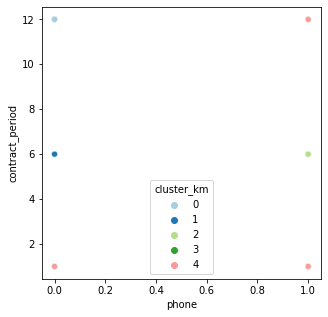

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



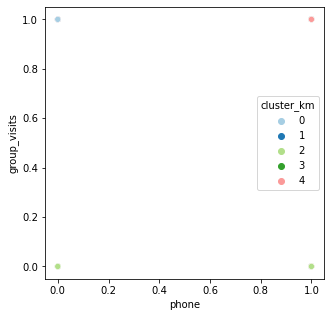

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



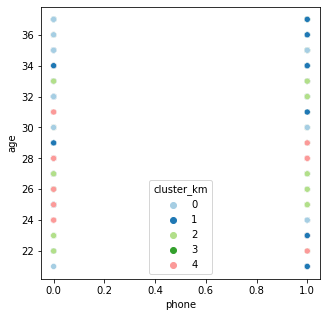

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



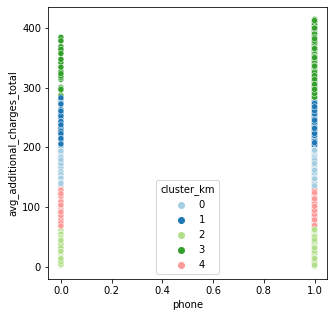

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



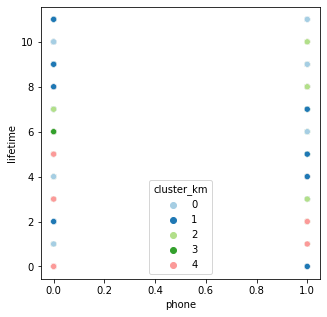

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



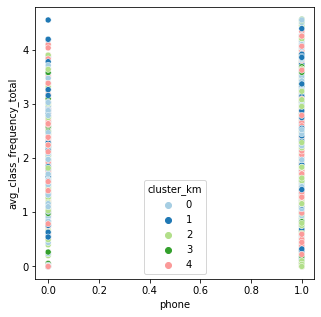

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



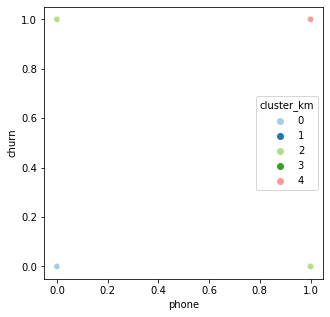

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



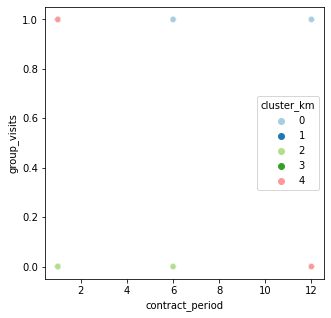

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



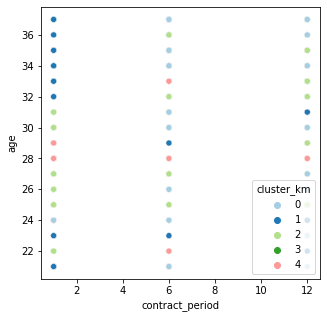

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



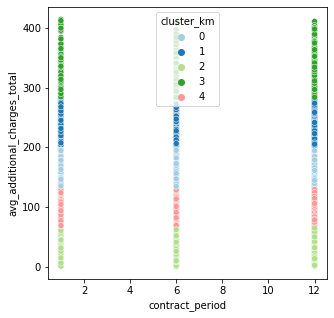

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



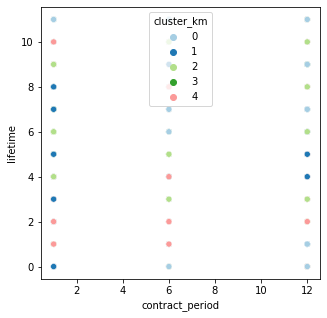

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



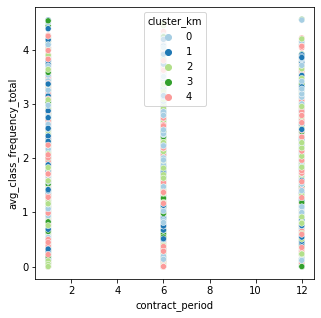

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



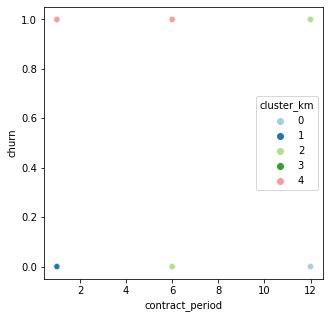

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



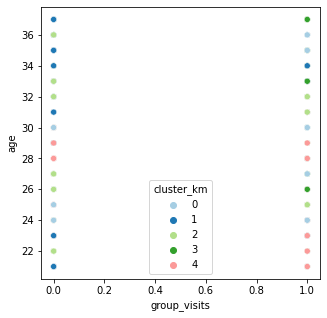

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



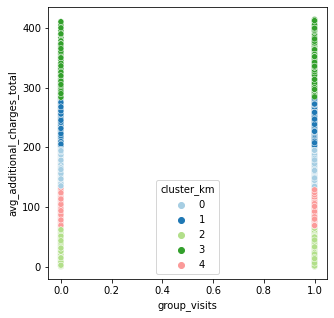

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



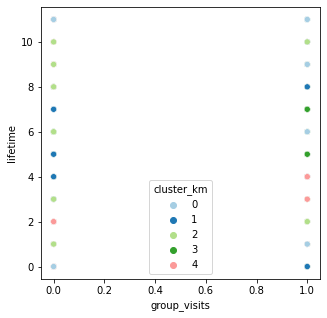

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



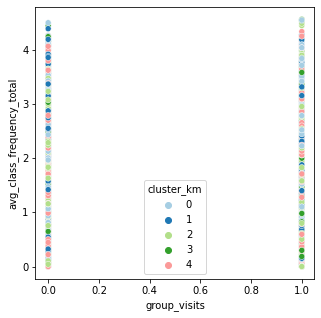

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



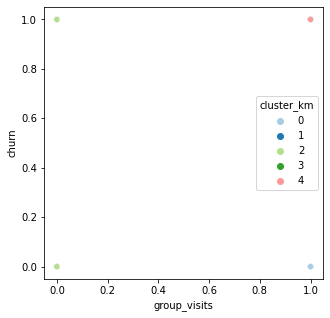

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



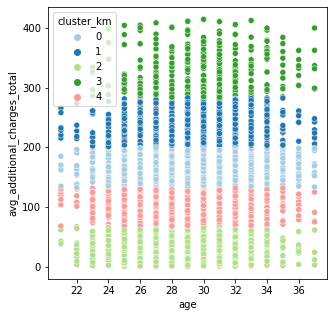

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



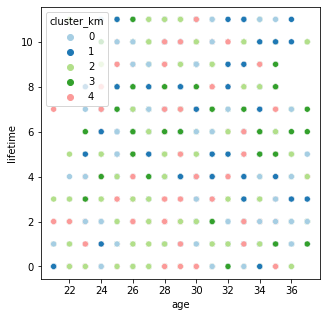

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



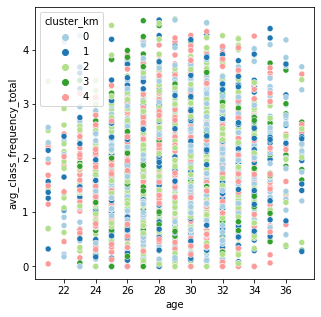

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



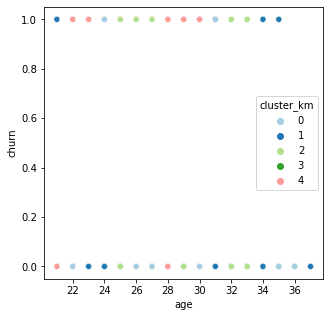

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



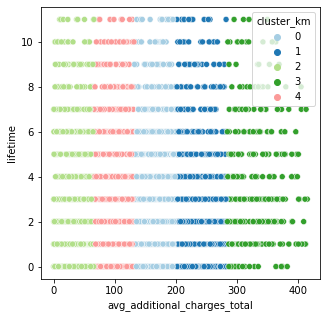

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



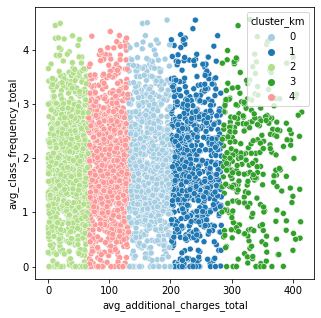

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



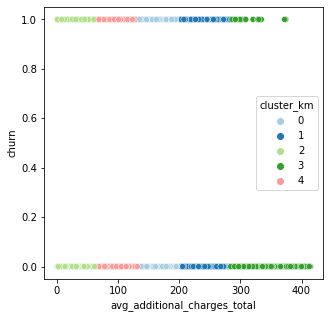

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



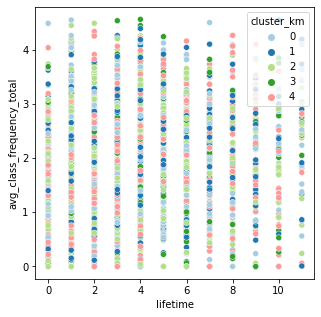

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



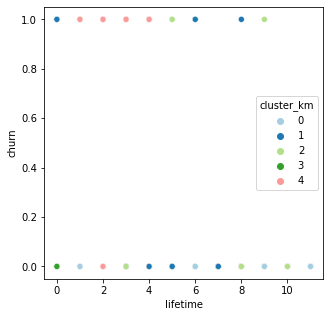

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



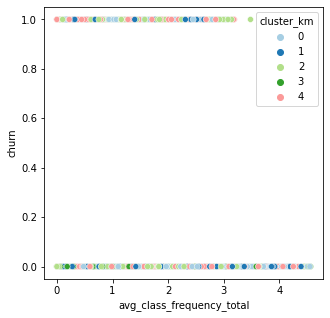

In [212]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    #plt.title('{x_name} vs {y_name}')
    plt.show()

col_pairs = list(itertools.combinations(data.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data, pair[0], pair[1], 'cluster_km')

Как и ожидалось, лучше всего разделяются кластеры по avg_additional_charges_total, avg_class_frequency_total, lifetime, avg_additional_charges_total

In [219]:
# посчитаем долю оттока для каждого кластера:
data.groupby('cluster_km', as_index = False)['churn'].mean() \
    .sort_values(by='churn', ascending=False)

cluster_km  churn
2           2   0.38
4           4   0.33
0           0   0.26
1           1   0.20
3           3   0.08

Можно сказать, что кластеры 2, 3 и 0 - больше всего склонные к оттоку, а вот клиенты, попавшие в кластер 3 - самые преданные  

<a id='conclusions'></a>
### 6. Выводы и рекоммендации

1. Для сети фитнес-клубов построили модель, предсказывающую отток клиентов.  
2. Построены модели логистической регрессии и случайного леса с различными гиперпараметрами. Обе модели показали очень хороший результат, немного впереди по метрикам качества оказалась модель случайного леса.  
3. Самыми важными для предсказания оказались возраст, сколько времени клиент посещает клуб, средняя частота посещений в неделю, суммарная выручка от других услуг фитнес - центра  
4. Провели кластеризацию ползователей. Выделили 5 классов.  
5. Самым "надежным" оказался класс с высокой недельной посещаемостью и высокими тратами на дополнительные услуги (кафе, прочее)  
6. К оттоку больше всего склонны те клиенты, которые редко и недолго ходят на занятия, не пользуются дополнительными услугами  
7. Следует уделять больше внимания продвижению дополнительных услуг среди клиентов, расширять из ассортимент, предлагать услуги на разный кошелек: чем больше фитнес-клуб вовлечен в жизнь клиента, тем тяжелее ему разорвать с ним 